# **The SABR Stochastic Volatility Model (LIGHT)**
We will here do our final calculations for the numerical results part of the thesis. The hyper-parameter tuning and building the model has been done in subsequent notebooks

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

We will start by importing the nessecary packages

In [2]:
import math
import pandas as pd
import datetime, os
import numpy as np
import numpy.random as npr
from pylab import plt, mpl

import threading

import time
import timeit

from scipy.stats import norm
from scipy import optimize
import scipy.integrate as integrate
import scipy.special as special 

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

In [3]:
'''import sys
!{sys.executable} -m pip install git+https://github.com/tensorflow/docs''';

In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Open the dataframe as a CSV.

In [5]:
#To read the import the csv-file, use:
raw_Options_input = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/SABR/SABR_data_input.csv")
raw_Options_output = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/SABR/SABR_data_output.csv")

#Creates some unnamed column in the beginning, delete it:
del raw_Options_input['Unnamed: 0']
del raw_Options_output['Unnamed: 0']


In [6]:
Options_input = raw_Options_input.copy()
Options_output = raw_Options_output.copy()

### **Data preparation**

We split our dataset into a training set and a test set (validation set is taken from the training set during model.fit).

In [7]:
# 96.67% for training and validating and the rest for testing
train_dataset = Options_input.sample(frac=0.96666666666667, random_state=42)
test_dataset = Options_input.drop(train_dataset.index)

train_labels = Options_output.sample(frac=0.96666666666667, random_state=42)
test_labels = Options_output.drop(train_labels.index)

Check the overall statistics

In [8]:
train_stats = train_dataset.describe().T
test_stats = test_dataset.describe().T

Separate the target values from the input values. These values are the values that we will train the model to predict. We will also normalize the data due to reasons described in the thesis

In [9]:
#normalize the data
def norm(x):
    return (x - train_stats['min']) / (train_stats['max']-train_stats['min'])
normed_train_data = norm(train_dataset).values

def norm_test(x):
    return (x - train_stats['min']) / (train_stats['max']-train_stats['min'])
normed_test_data = norm_test(test_dataset).values

#make the labels into numpy array just like the normed training data
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

#check the shapes
print("Input train data:", normed_train_data.shape, " Output train data:", train_labels.shape)
print("Input test data:", normed_test_data.shape, " Output test data:", test_labels.shape)

Input train data: (290000, 14)  Output train data: (290000, 10)
Input test data: (10000, 14)  Output test data: (10000, 10)


## **The model**

Now let's build the neural network with one hidden layer using tensorflow and a Sequential API.

Note: This model has been primarily chosen based on the same hyperparameters as in McGhee's paper. We have also done hyper-parameter tuning in some of the other notebooks in order to find out which hyper-parameters fits out data the best.

In [10]:
input_size = len(train_dataset.keys())
output_size = 10
hidden_layer_size = 250

#weight and bias initializers
weights_initializer = keras.initializers.GlorotUniform(seed=42)
bias_initializer = keras.initializers.Zeros()

def build_model():
    model = keras.models.Sequential([
            #Layer to be used as an entry point into a Network
            keras.layers.InputLayer(input_shape=[len(train_dataset.keys())]),
        
            #Dense layer
            keras.layers.Dense(hidden_layer_size, activation='relu', kernel_initializer = weights_initializer,
                               bias_initializer = bias_initializer, name='Layer_1'),
        
            #activation function is linear since we are doing regression
            keras.layers.Dense(output_size, activation='relu', name='Output_layer')
                                ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999,
                             epsilon=1e-07, amsgrad=False, name='Adam')
    
    #Compiling the model
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=['mean_squared_error']) #Computes the mean squared error between y_true and y_pred

    return model

In [11]:
model = build_model()

Inspect the model using .summary to get a simple description of the model (there should be no non-trainable parameters)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Dense)              (None, 250)               3750      
_________________________________________________________________
Output_layer (Dense)         (None, 10)                2510      
Total params: 6,260
Trainable params: 6,260
Non-trainable params: 0
_________________________________________________________________


Now, try out the model. Take a batch of 10 examples from the training data and call model.predict on it. There should be no NaN, otherwise something is wrong

In [13]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.03948815, 0.00296742, 0.        , 0.06542762, 0.32705373,
        0.26271403, 0.25920868, 0.        , 0.13697922, 0.        ],
       [0.11479668, 0.08593976, 0.        , 0.09319015, 0.2765116 ,
        0.26346466, 0.14725196, 0.        , 0.04771911, 0.        ],
       [0.06506236, 0.        , 0.        , 0.06359224, 0.210925  ,
        0.20322028, 0.09418657, 0.10129184, 0.00154418, 0.        ],
       [0.09540553, 0.10003324, 0.        , 0.14349306, 0.3250188 ,
        0.20521861, 0.20978925, 0.        , 0.08192088, 0.12951924],
       [0.00982967, 0.00249803, 0.        , 0.10031808, 0.17562748,
        0.18924728, 0.10460052, 0.        , 0.03818114, 0.        ],
       [0.06773334, 0.03794886, 0.        , 0.05163155, 0.24071705,
        0.24120647, 0.14994754, 0.        , 0.07226899, 0.        ],
       [0.06050424, 0.        , 0.        , 0.06773941, 0.23324335,
        0.20501822, 0.07759797, 0.10813729, 0.        , 0.        ],
       [0.1432166 , 0.09733287, 0.       

Train the model for #max_epochs epochs, and record the training and validation accuracy in the history object.

In [14]:
%%time

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

batch_size = 32
max_epochs = 1000000

#Stop training if the val_loss has not improved over the last #number of epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=200)

#log our training in order to display it to tensorboard (provides great visual effects)
NAME = "SABR_Tensorboard-{}".format(int(time.time()))
tensorboard_callback = TensorBoard(log_dir="logs/fit/{}".format(NAME), histogram_freq=1)

#Initialize TimeStopping callback 
time_stopping_callback = tfa.callbacks.TimeStopping(seconds=10*60*60, verbose=1)

#Model checkpoint (save the best weights and biases) (change monitor to 'mean_squared_error')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="logs/fit/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='min', save_freq='epoch', options=None)

#fit the model and save it under history
history = model.fit(normed_train_data, train_labels, 
         batch_size=batch_size, 
         epochs=max_epochs,
         validation_split=0.08,
         verbose=0,
         callbacks=[early_stopping, PrintDot(), time_stopping_callback, tensorboard_callback])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [15]:
%tensorboard --logdir logs/fit

Visualize the model's training progress using the stats stored in the history object.

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
1319,0.000001,0.000001,0.000002,0.000002,1319
1320,0.000001,0.000001,0.000001,0.000001,1320
1321,0.000001,0.000001,0.000002,0.000002,1321
1322,0.000001,0.000001,0.000001,0.000001,1322
1323,0.000001,0.000001,0.000002,0.000002,1323


## **Visualization**

Inspirations:
- https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcess
- https://www.kite.com/python/answers/how-to-plot-on-a-log-scale-with-matplotlib-in-python
- https://stackoverflow.com/questions/60683901/tensorboard-smoothing

Make a simple plot of the training (there is no need for this as tensorboard does it already, but still great visualizer for printing)

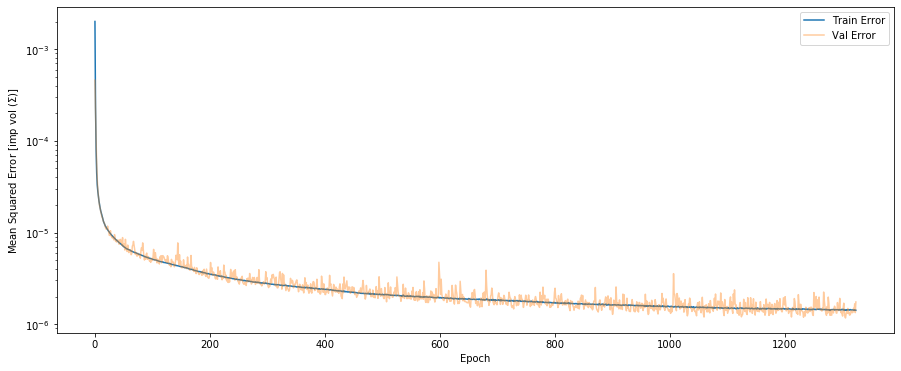

In [17]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(15, 6))
    plt.yscale("log")
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error [imp vol ($\Sigma$)]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'].ewm(com=0.5).mean(),
               label = 'Val Error', alpha=0.4)
    plt.legend()
    
    #plt.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/SABR/SABR_mse.png',bbox_inches='tight')

    plt.show()


plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 1.876111e-06

Let's see how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world (we print the mean_squared_error).

In [18]:
loss, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Squared Error: {:5.10f} imp vol".format(mse))

Testing set Mean Squared Error: 0.0000019216 imp vol


## **ERROR DISTRIBUTION**

Finally, predict the implied volatility values using data in the testing set

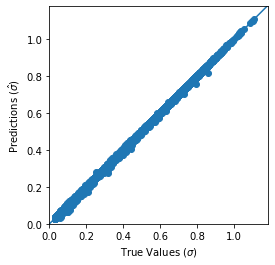

In [19]:
test_predictions = model.predict(normed_test_data).flatten(order="C")

plt.scatter(test_labels, test_predictions)
plt.xlabel(r'True Values ($\sigma$)')
plt.ylabel(r'Predictions ($\hat{\sigma}$)')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts really well. Let's take a look at the error distribution.

### Distribution of prediction errors

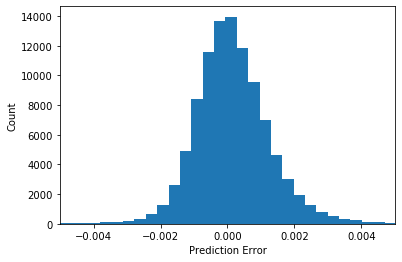

In [20]:
test_labelz = test_labels.flatten(order="C")

error = test_predictions - test_labelz
plt.hist(error, bins = 200)
plt.xlim(-0.005, 0.005)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

Almost perfect gaussian distribution.

In [21]:
#Calculate R-squared

def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

r_squared(test_labelz, test_predictions)

0.9999287434640662

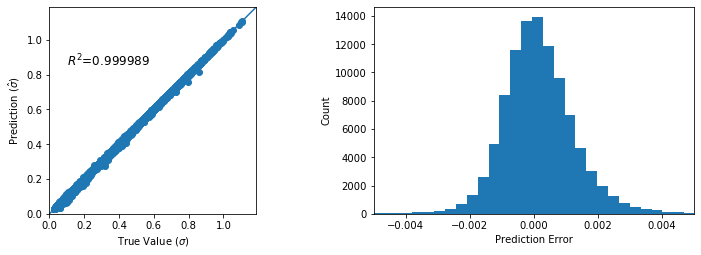

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
fig.tight_layout(pad=3.0)

ax1.annotate(r'$R^2$=0.999989',xy=(0.1, 0.85), fontsize=12)
ax1.scatter(test_labels, test_predictions)
ax1.set_xlabel(r'True Value ($\sigma$)')
ax1.set_ylabel(r'Prediction ($\hat{\sigma}$)')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0,1.19])
ax1.set_ylim([0,1.19])
ax1.plot([-100, 100], [-100, 100])

ax2.hist(error, bins = 200)
ax2.set_xlim(-0.005, 0.005)
ax2.set_xlabel("Prediction Error")
ax2.set_ylabel("Count");

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/SABR/SABR_errordist2.png',bbox_inches='tight')


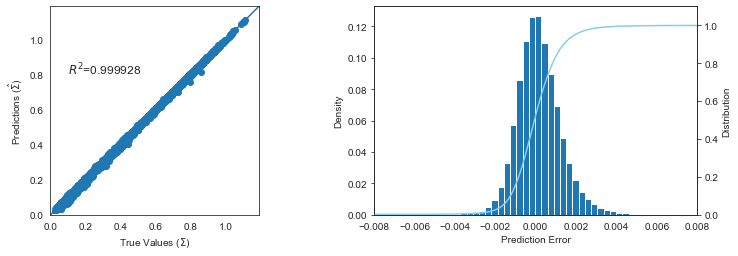

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
fig.tight_layout(pad=3.0)

ax1.annotate(r'$R^2$=0.999928',xy=(0.1, 0.8), fontsize=12)
ax1.scatter(test_labelz, test_predictions)
ax1.set_xlabel(r'True Values ($\Sigma$)')
ax1.set_ylabel(r'Predictions ($\hat{\Sigma}$)')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0,1.19])
ax1.set_ylim([0,1.19])
_ = ax1.plot([-100, 100], [-100, 100])

ax2.hist(x=error, bins=220, weights=np.zeros_like(error) + 1. / error.size)
ax2.set_xlim(-0.008,0.008)
ax2.set_xlabel("Prediction Error")
ax2.set_ylabel("Density")
ax3 = ax2.twinx()
# evaluate the histogram
values, base = np.histogram(error, bins=500)
#evaluate the cumulative
cumulative = np.cumsum(values)/100000
ax3.plot(base[:-1], cumulative, color = "skyblue")
ax3.set_ylim(0.0,1.1)
ax3.set_ylabel("Distribution");

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/SABR/SABR_errordist_Fast.png',bbox_inches='tight')

### Smile error shown as a normal line chart

We here show a normal line-plot where we can see that the real analytic heston formula (red) and the ANN (blue) are almost identical

In [24]:
from tabulate import tabulate

In [25]:
prediction_1 = model.predict(normed_test_data[1000:1001]).flatten() * 100
realprediction_1 = test_labels[1000:1001].flatten() * 100
Strikes = ((test_dataset[['K_0', 'K_1', 'K_2', 'K_3', 'K_4', 'K_5','K_6', 'K_7', 'K_8', 'K_9']].iloc[1000:1001]).to_numpy()).flatten()

The input values that we use are

In [26]:
data_outputs = test_dataset[1000:1001]
data_outputs

,T,sig_0,xi,rho,K_0,K_1,K_2,K_3,K_4,K_5,K_6,K_7,K_8,K_9
30682,0.30494,0.35,0.932255,-0.5,0.40115,0.471158,0.553383,0.649958,0.763387,0.896611,1.053084,1.236866,1.45272,1.706245


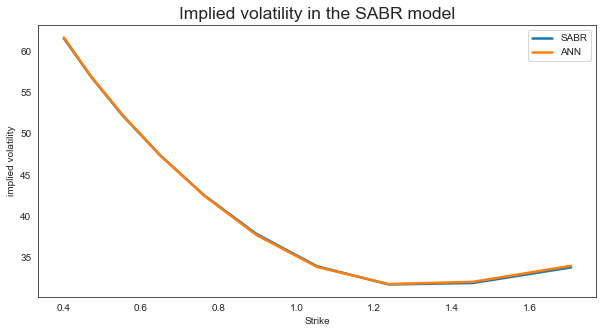

In [27]:
plt.figure(figsize=(10,5))
sns.set_style("white")
ax = sns.lineplot(x=Strikes, y=realprediction_1, color='#1f77b4', linewidth=2.5) #blue color
ax = sns.lineplot(x=Strikes, y=prediction_1, color='#ff7f0e', linewidth=2.5) #orange color
ax.axes.set_title("Implied volatility in the SABR model", fontsize=17.5);
ax.set(xlabel="Strike", ylabel="implied volatility")
ax.legend(['SABR', 'ANN']);

One more

In [28]:
prediction_2 = model.predict(normed_test_data[4013:4014]).flatten() * 100
realprediction_2 = test_labels[4013:4014].flatten() * 100
Strikes_2 = ((test_dataset[['K_0', 'K_1', 'K_2', 'K_3', 'K_4', 'K_5','K_6', 'K_7', 'K_8', 'K_9']].iloc[4013:4014]).to_numpy()).flatten()

The input values that we use are

In [29]:
# 1 year is equal to (1 / 0.002740) days
data_outputs_2 = test_dataset[4013:4014]
data_outputs_2

,T,sig_0,xi,rho,K_0,K_1,K_2,K_3,K_4,K_5,K_6,K_7,K_8,K_9
122772,0.572148,0.311064,0.30219,0.360771,0.484607,0.583333,0.702171,0.845221,1.017412,1.224683,1.47418,1.774506,2.136015,2.571173


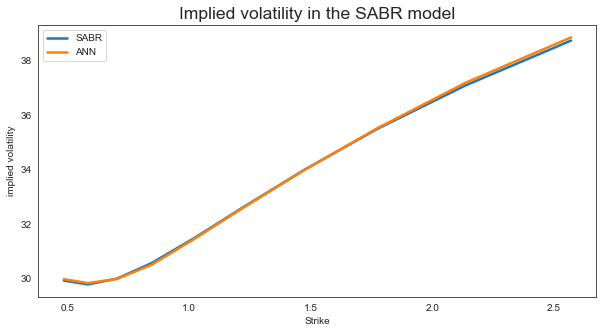

In [30]:
plt.figure(figsize=(10,5))
sns.set_style("white")
ax = sns.lineplot(x=Strikes_2, y=realprediction_2, color='#1f77b4', linewidth=2.5) #blue color
ax = sns.lineplot(x=Strikes_2, y=prediction_2, color='#ff7f0e', linewidth=2.5) #orange color
ax.axes.set_title("Implied volatility in the SABR model", fontsize=17.5);
ax.set(xlabel="Strike", ylabel="implied volatility")
ax.legend(['SABR', 'ANN']);

Lets just smooth the function by interpolating between our known values:

- https://www.kite.com/python/answers/how-to-plot-a-smooth-line-with-matplotlib-in-python
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html

In [31]:
from scipy.interpolate import CubicSpline
import matplotlib.ticker as mtick

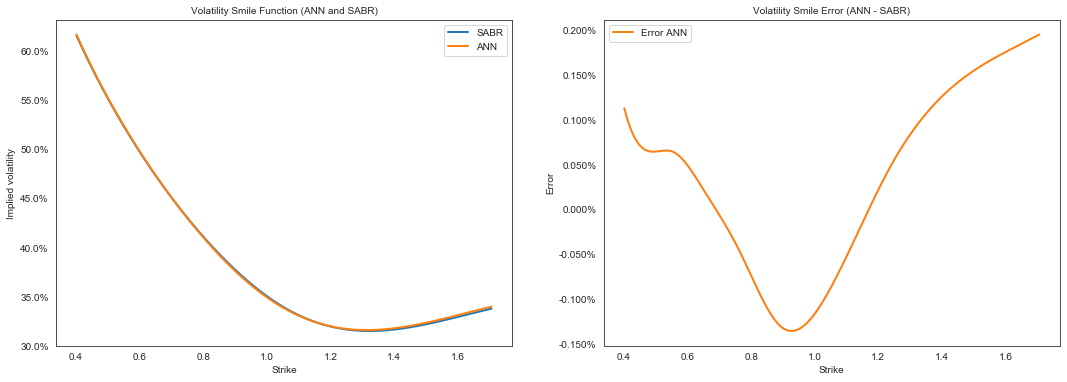

In [32]:
# interpolation for the predicted outputs
x_new = np.linspace(Strikes[0], Strikes[9], 5000)
a_Spline = CubicSpline(Strikes, prediction_1)
y_new = a_Spline(x_new)

#interpolation for the real output
real_Spline =  CubicSpline(Strikes, realprediction_1)
yreal_new = real_Spline(x_new)

#volatility smile error
y_error = y_new - yreal_new

#The plot itself
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
sns.set_style("white")

sns.lineplot(x=x_new, y=yreal_new, color='#1f77b4', linewidth=2., ax=ax1)
sns.lineplot(x=x_new, y=y_new, color='#ff7f0e', linewidth=2., ax=ax1)
ax1.axes.set_title("Volatility Smile Function (ANN and SABR)", fontsize=10)
ax1.set(xlabel="Strike", ylabel="Implied volatility")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.legend(['SABR', 'ANN']);

sns.lineplot(x=x_new, y=y_error, color='#ff7f0e', linewidth=2., ax=ax2)
ax2.axes.set_title("Volatility Smile Error (ANN - SABR)", fontsize=10)
ax2.set(xlabel="Strike", ylabel="Error")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.legend(['Error ANN']);

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/SABR/SABR_smiles.png',bbox_inches='tight')

In [33]:
print("The above smile has an error in the range: ", min(y_error),",", max(y_error))

The above smile has an error in the range:  -0.13566623721483495 , 0.19494754158514382


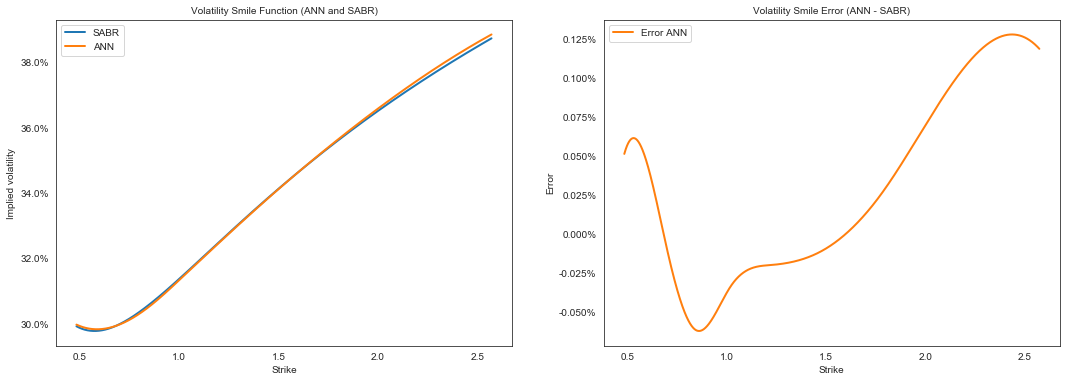

In [34]:
# interpolation for the predicted outputs
x_2 = np.linspace(Strikes_2[0], Strikes_2[9], 5000)
Spline_2 = CubicSpline(Strikes_2, prediction_2)
y_2 = Spline_2(x_2)

#interpolation for the real output
Spline_r2 =  CubicSpline(Strikes_2, realprediction_2)
y_r2 = Spline_r2(x_2)

#volatility smile error
y2_error = y_2 - y_r2


#The plot itself
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
sns.set_style("white")

sns.lineplot(x=x_2, y=y_r2, color='#1f77b4', linewidth=2., ax=ax1)
sns.lineplot(x=x_2, y=y_2, color='#ff7f0e', linewidth=2., ax=ax1)
ax1.axes.set_title("Volatility Smile Function (ANN and SABR)", fontsize=10)
ax1.set(xlabel="Strike", ylabel="Implied volatility")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.legend(['SABR', 'ANN']);

sns.lineplot(x=x_2, y=y2_error, color='#ff7f0e', linewidth=2., ax=ax2)
ax2.axes.set_title("Volatility Smile Error (ANN - SABR)", fontsize=10)
ax2.set(xlabel="Strike", ylabel="Error")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.legend(['Error ANN']);

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/SABR/SABR_smiles2.png',bbox_inches='tight')

In [35]:
print("The above smile has an error in the range: ", min(y2_error),",", max(y2_error))

The above smile has an error in the range:  -0.06191033933145462 , 0.12753978610162164


### Percent deviation of errors scatterplot

In [36]:
#percent_deviation = pd.DataFrame(np.divide(np.subtract(model.predict(normed_test_data),test_labels),test_labels)*100)
percent_deviation = pd.DataFrame(np.subtract(model.predict(normed_test_data),test_labels)*100)

In [37]:
df = pd.DataFrame(percent_deviation)
print("The lowest mean squared error:\n", df.min())
print("\nThe highest mean squared error:\n", df.max())

The lowest mean squared error:
 0   -1.194500
1   -1.535414
2   -0.763496
3   -0.725246
4   -0.556063
5   -0.920086
6   -1.103685
7   -2.649058
8   -3.681658
9   -4.386792
dtype: float64

The highest mean squared error:
 0    1.363525
1    2.404897
2    1.956425
3    2.013716
4    1.685480
5    1.393656
6    1.084693
7    0.815863
8    1.075260
9    1.467796
dtype: float64


In [38]:
test_dataset_T = []
test_dataset_sigma = []
test_dataset_xi = []
test_dataset_rho = []

for i in range(10):
    test_dataset_T.append(test_dataset['T'])
    test_dataset_sigma.append(test_dataset['sig_0'])
    test_dataset_xi.append(test_dataset['xi'])
    test_dataset_rho.append(test_dataset['rho'])

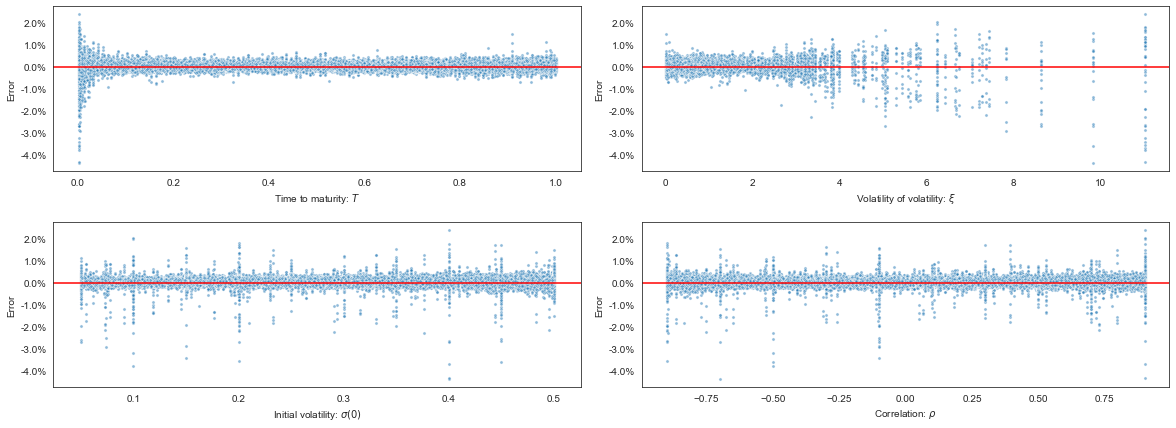

In [39]:
fig = plt.figure(figsize=(20, 7))
gs = fig.add_gridspec(4, 8, wspace=0.7, hspace=0.9)
sns.set_style("white")

ax0 = plt.subplot(gs[0:2,0:4])
ax0.set_ylabel("Error")
ax0.set_xlabel(r"Time to maturity: $T$")
ax0.axhline(linewidth=1.5, color='r')
ax0.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_T).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax0,
               color = '#1f77b4',  alpha=0.5, s=10)

ax1 = plt.subplot(gs[2:4,0:4])
ax1.set_ylabel("Error")
ax1.set_xlabel(r"Initial volatility: $\sigma(0)$")
ax1.axhline(linewidth=1.5, color='r')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_sigma).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax1,
               color = '#1f77b4',  alpha=0.5, s=10)

ax2 = plt.subplot(gs[0:2,4:8])
ax2.set_ylabel("Error")
ax2.set_xlabel(r"Volatility of volatility: $\xi$")
ax2.axhline(linewidth=1.5, color='r')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_xi).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax2,
               color = '#1f77b4',  alpha=0.5, s=10)

ax3 = plt.subplot(gs[2:4,4:8])
ax3.set_ylabel("Error")
ax3.set_xlabel(r"Correlation: $\rho$")
ax3.axhline(linewidth=1.5, color='r')
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_rho).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax3,
               color = '#1f77b4',  alpha=0.5, s=10);


Lets include the strikes.

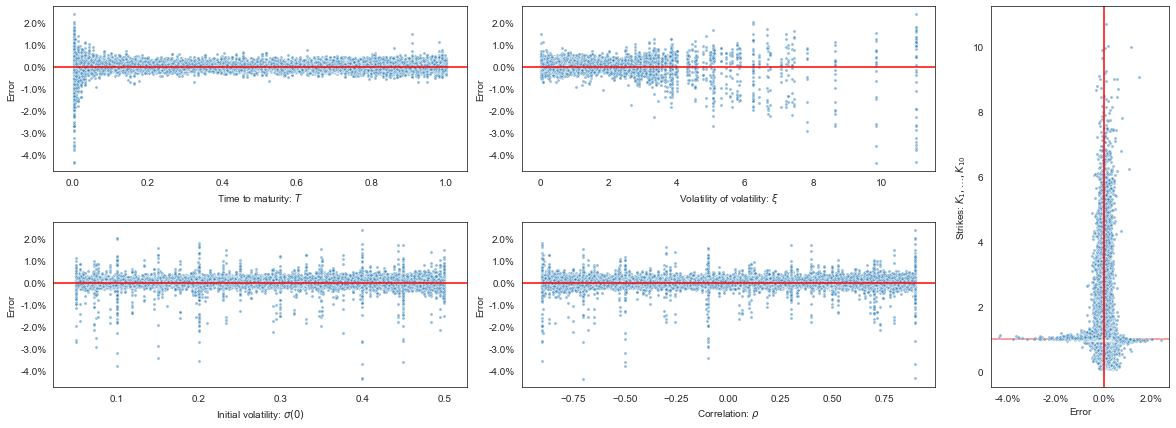

In [63]:
fig = plt.figure(figsize=(20, 7))
gs = fig.add_gridspec(4, 10, wspace=0.9, hspace=0.9)
sns.set_style("white")

ax0 = plt.subplot(gs[0:2,0:4])
ax0.set_ylabel("Error")
ax0.set_xlabel(r"Time to maturity: $T$")
ax0.axhline(linewidth=1.5, color='r')
ax0.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_T).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax0,
               color = '#1f77b4',  alpha=0.5, s=10)

ax1 = plt.subplot(gs[2:4,0:4])
ax1.set_ylabel("Error")
ax1.set_xlabel(r"Initial volatility: $\sigma(0)$")
ax1.axhline(linewidth=1.5, color='r')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_sigma).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax1,
               color = '#1f77b4',  alpha=0.5, s=10)

ax2 = plt.subplot(gs[0:2,4:8])
ax2.set_ylabel("Error")
ax2.set_xlabel(r"Volatility of volatility: $\xi$")
ax2.axhline(linewidth=1.5, color='r')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_xi).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax2,
               color = '#1f77b4',  alpha=0.5, s=10)

ax3 = plt.subplot(gs[2:4,4:8])
ax3.set_ylabel("Error")
ax3.set_xlabel(r"Correlation: $\rho$")
ax3.axhline(linewidth=1.5, color='r')
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=np.array(test_dataset_rho).flatten(), y=(percent_deviation.values).flatten(order='F'), ax=ax3,
               color = '#1f77b4',  alpha=0.5, s=10);

ax4 = plt.subplot(gs[0:4,8:10])
ax4.set_ylabel(r"Strikes: $K_1,\dots,K_{10}$")
ax4.set_xlabel("Error")
ax4.axvline(linewidth=1.5, color='r')
ax4.axhline(y=1,linewidth=1.5, color='r', zorder=0, alpha=0.5)
ax4.xaxis.set_major_formatter(mtick.PercentFormatter())
sns.scatterplot(x=(percent_deviation.to_numpy()).flatten(order='F'),
                y=(test_dataset[['K_0', 'K_1', 'K_2', 'K_3', 'K_4', 'K_5','K_6', 'K_7', 'K_8', 'K_9']].to_numpy()).flatten(order='F'),
                ax=ax4, color = '#1f77b4',  alpha=0.5, s=10);

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/SABR/SABR_scatterplot_Fast.png',bbox_inches='tight')

## **CDF and PDF**

- https://machinelearningmastery.com/statistical-data-distributions/
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.cdf.html
- https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python
- https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html
- https://en.wikipedia.org/wiki/Finite_difference


In order to find the PDF (and from that the CDF) we will use the Breeden and Litzenberger formula. Also, to compute the first and second derivative of the pdf we will use numerical differentiation.

$\textbf{PDF}$: 
A probability density function (PDF), or density of a continuous random variable, is a function whose value at any given sample (or point) in the sample space (the set of possible values taken by the random variable) can be interpreted as providing a relative likelihood that the value of the random variable would equal that sample. In other words, while the absolute likelihood for a continuous random variable to take on any particular value is 0 (since there are an infinite set of possible values to begin with), the value of the PDF at two different samples can be used to infer, in any particular draw of the random variable, how much more likely it is that the random variable would equal one sample compared to the other sample.

In a more precise sense, the PDF is used to specify the probability of the random variable falling within a particular range of values, as opposed to taking on any one value. This probability is given by the integral of this variable's PDF over that range—that is, it is given by the area under the density function but above the horizontal axis and between the lowest and greatest values of the range. The probability density function is nonnegative everywhere, and its integral over the entire space is equal to 1.

$$
f(X)=\frac{d(F(x))}{dx}
$$

$\textbf{CDF}$: 
The cumulative distribution function (CDF) of a real-valued random variable X, or just distribution function of X, evaluated at x, is the probability that X will take a value less than or equal to x.

In the case of a scalar continuous distribution, it gives the area under the probability density function from minus infinity to x. 

$$
F(X)=\int_{0}^{x}f(s) \qquad \text{where s is a dummy integration variable}
$$

In [41]:
from scipy.integrate import quad
from scipy.stats import norm
from scipy import stats

In [42]:
data_outputs3 = test_dataset[4059:4060]
data_outputs3

,T,sig_0,xi,rho,K_0,K_1,K_2,K_3,K_4,K_5,K_6,K_7,K_8,K_9
124019,0.651897,0.408472,0.662019,-0.310332,0.226861,0.29896,0.393973,0.519183,0.684185,0.901627,1.188174,1.565789,2.063415,2.719192


In [43]:
pred_cdfpdf = model.predict(normed_test_data[4059:4060]).flatten()
real_cdfpdf = test_labels[4059:4060].flatten()
K_cdfpdf = ((test_dataset[['K_0', 'K_1', 'K_2', 'K_3', 'K_4', 'K_5','K_6', 'K_7', 'K_8', 'K_9']].iloc[4059:4060]).to_numpy()).flatten()
inputs_data = (data_outputs3.values).flatten()

#plt.plot(K_cdfpdf, pred_cdfpdf)
#plt.plot(K_cdfpdf, real_cdfpdf);

Interpolate the strikes and implied volatility

In [44]:
x = np.linspace(K_cdfpdf[0], K_cdfpdf[9], 500)
cs = CubicSpline(K_cdfpdf, pred_cdfpdf)
y = cs(x)

cs_real = CubicSpline(K_cdfpdf, real_cdfpdf)
y_real = cs_real(x)
#plt.plot(x, y);

In order to calculate the probability density function, we will use the Breeden and Litzenberger formula:
$$
f_Q(X_T)=e^{r\tau}\frac{\partial C_{BS}(X_T)}{\partial X_T^2}\approx e^{r\tau}\frac{C(K+\Delta_K,T)-2C(K,T)+C(K-\Delta_K,T)}{(\Delta_K)^2}
$$

We will therefore calculate the BSM call prices using the above strikes and implied volatilities

In [45]:
def euro_vanilla(S_t, K, t, T, r, sigma, option = ''):
    d1 = (np.log(S_t/K)+(r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
    d2 = (np.log(S_t/K)+(r-0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
    
    if option == 'call':
        result = S_t*norm.cdf(d1, 0.0, 1.0)-K*np.exp(-r*(T-t))*norm.cdf(d2, 0.0, 1.0)
    if option == 'put':
        result = K*np.exp(-r*(T-t))*norm.cdf(-d2, 0.0, 1.0)-S_t*norm.cdf(-d1, 0.0, 1.0)
    
    return result

In [46]:
#inputs: 
S = 1.
t = 0.
T = (data_outputs3.values).flatten()[0]
r = 0.

call_pred = []
call_real = []
for i in range(len(x)):
    BSM_pred = euro_vanilla(S_t=S, K=x[i], t=t, T=T, r=r, sigma=y[i], option = 'call')
    call_pred.append(BSM_pred)
    
    BSM_real = euro_vanilla(S_t=S, K=x[i], t=t, T=T, r=r, sigma=y_real[i], option = 'call')
    call_real.append(BSM_real)

Now we will use the above breeden litzenberger formula

In [47]:
pdf_pred = []
pdf_real = []
for i in range(1,len(x)-1):
    PDF_pred = np.exp(r*T) * (call_pred[i+1] - 2*call_pred[i] + call_pred[i-1]) / ((x[i+1] - x[i])**2)
    pdf_pred.append(PDF_pred)
    
    PDF_real = np.exp(r*T) * (call_real[i+1] - 2*call_real[i] + call_real[i-1]) / ((x[i+1] - x[i])**2)
    pdf_real.append(PDF_real)

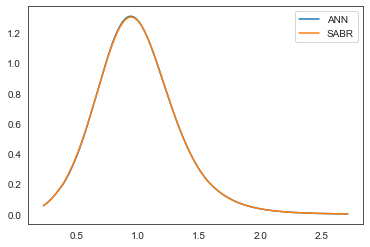

In [48]:
plt.plot(x[1:499],pdf_pred)
plt.plot(x[1:499],pdf_real)
plt.legend(['ANN', 'SABR'])

And for the CDF we simply do the following: 

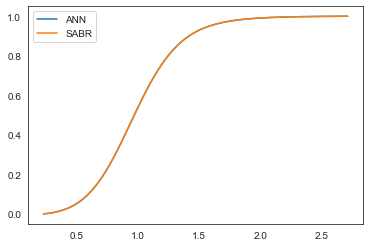

In [49]:
cdf_pred = np.cumsum(pdf_pred) / np.sum(pdf_pred)
cdf_real = np.cumsum(pdf_real) / np.sum(pdf_real)
plt.plot(x[1:499], cdf_pred)
plt.plot(x[1:499], cdf_real)
plt.legend(['ANN', 'SABR'])

Now we calculate the percent error (in terms of the ANN and the true SABR model) of the smile, the PDF and the CDF

In [50]:
#Smile error
smile_error = y - y_real
#plt.plot(x, smile_error)

#CDF error
cdf_error = cdf_pred-cdf_real
#plt.plot(x[1:499],cdf_error)

#PDF error
pdf_error = np.asarray(pdf_pred) - np.asarray(pdf_real)
#plt.plot(x[1:499],pdf_error)

In [51]:
'''
If we want to se what the min, max, mean, variance, skewness, kurtosis is
''';
#stats.describe(smile_error)
#stats.describe(cdf_error)
#stats.describe(pdf_error)

Collect it all and plot it such that it looks like McGhees work on page 17

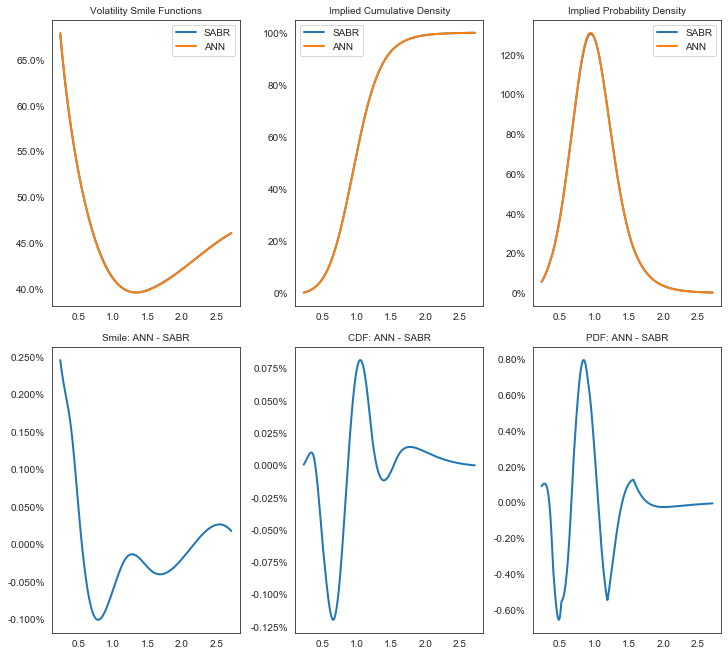

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(10,9), constrained_layout=True)
sns.set_style("white")

sns.lineplot(x=x[1:499], y=y_real[1:499]*100, color='#1f77b4', linewidth=2., ax=axs[0,0])
sns.lineplot(x=x[1:499], y=y[1:499]*100, color='#ff7f0e', linewidth=2., ax=axs[0,0])
axs[0,0].axes.set_title("Volatility Smile Functions", fontsize=10)
#ax1.set(xlabel="Strike", ylabel="Implied volatility")
axs[0,0].yaxis.set_major_formatter(mtick.PercentFormatter())
axs[0,0].legend(['SABR', 'ANN']);

sns.lineplot(x=x[1:499], y=cdf_real*100, color='#1f77b4', linewidth=2., ax=axs[0,1])
sns.lineplot(x=x[1:499], y=cdf_pred*100, color='#ff7f0e', linewidth=2., ax=axs[0,1])
axs[0,1].axes.set_title("Implied Cumulative Density", fontsize=10)
#ax2.set(xlabel="Strike", ylabel="Error")
axs[0,1].yaxis.set_major_formatter(mtick.PercentFormatter())
axs[0,1].legend(['SABR', 'ANN'])

sns.lineplot(x=x[1:499], y=np.asarray(pdf_real)*100, color='#1f77b4', linewidth=2., ax=axs[0,2])
sns.lineplot(x=x[1:499], y=np.asarray(pdf_pred)*100, color='#ff7f0e', linewidth=2., ax=axs[0,2])
axs[0,2].axes.set_title("Implied Probability Density", fontsize=10)
#ax2.set(xlabel="Strike", ylabel="Error")
axs[0,2].yaxis.set_major_formatter(mtick.PercentFormatter())
axs[0,2].legend(['SABR', 'ANN'])

sns.lineplot(x=x[1:499], y=smile_error[1:499]*100, color='#1f77b4', linewidth=2., ax=axs[1,0])
axs[1,0].axes.set_title("Smile: ANN - SABR", fontsize=10)
axs[1,0].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.lineplot(x=x[1:499], y=cdf_error*100, color='#1f77b4', linewidth=2., ax=axs[1,1])
axs[1,1].axes.set_title("CDF: ANN - SABR", fontsize=10)
axs[1,1].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.lineplot(x=x[1:499], y=pdf_error*100, color='#1f77b4', linewidth=2., ax=axs[1,2])
axs[1,2].axes.set_title("PDF: ANN - SABR", fontsize=10)
axs[1,2].yaxis.set_major_formatter(mtick.PercentFormatter())

#fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/SABR/SABR_cdfpdf.png',bbox_inches='tight')

## **SPEED PERFORMANCE**

Lets test how fast our model is at predicting vs just calculating using the standard Heston way. 
We start with the model prediction time

Inspirations:
- https://stackoverflow.com/questions/60267911/keras-inconsistent-prediction-time
- https://serverfault.com/questions/48455/what-are-the-differences-between-wall-clock-time-user-time-and-cpu-time#:~:text=In%20contrast%20to%20CPU%20time,for%20resources%20to%20become%20available. (model.predict(input) seems slower than model(input))

### SABR neural network

We run the test on our test dataset which contains (10000,7) datapoints i.e. 10000 smiles or 100000 implied volatilities

In [53]:
%%timeit
model(normed_test_data)

10.6 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
%%timeit
model.predict(normed_test_data)

167 ms ± 9.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


predicting using "model" is the fastest and takes 41.2 milliseconds (0.0412 sec) which is 0.00000412 sec per smile and 0.000000412 (4.12e^-7) sec per volatility

### SABR analytic model

Now, lets calculate the time it takes to run 1 implied vol but on our standard SABR model. Instead of running the SABR imp vol code in python, we will use C++ to get a more justifiable comparison. We will here include a picture of the resulting output.

In [55]:
from IPython.display import Image

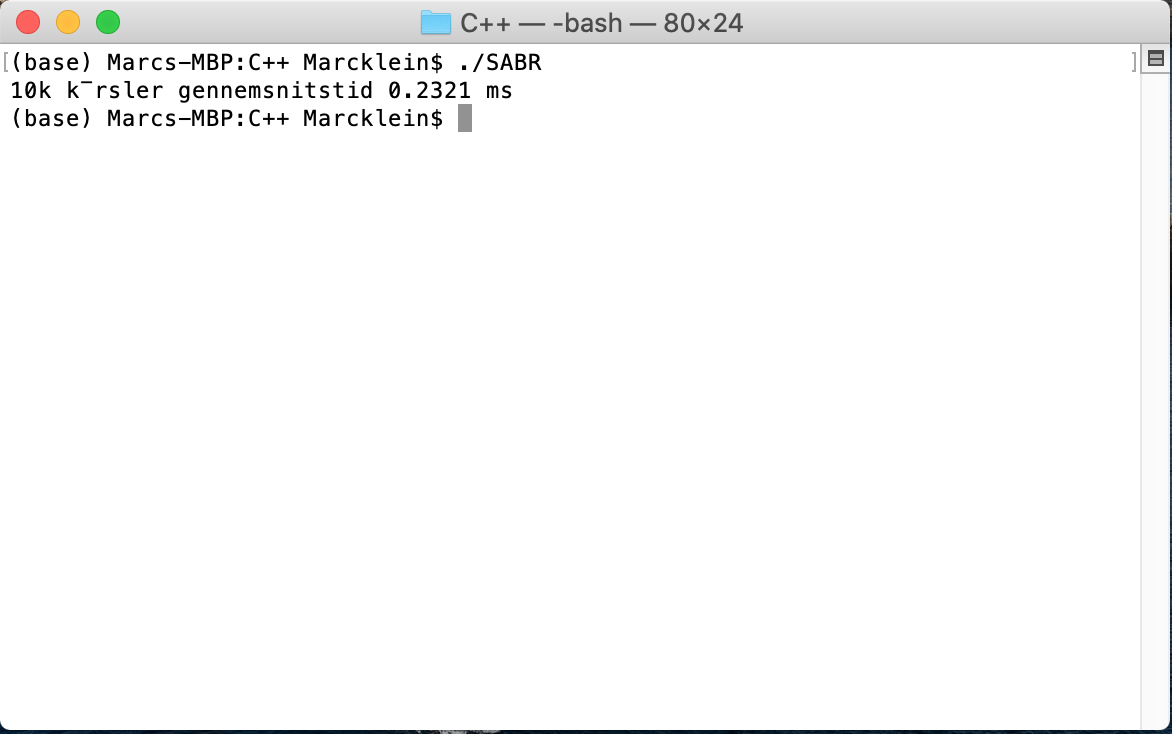

In [56]:
Image("/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/SABR/SABR_cpp2.png")

Calculating 1 implied volatility (average of 1k runs) using the simple SABR model takes 0.23 microseconds (2.3e^-7). Calculating one smile takes  2.3^-7*10= 2.3^-6sec

**Result:**

This means that the normal model is is 4.1/2.3=1.8 times faster than the SABR neural network calculator

## **NOTES/TRIALS FOR LATER USE**

In [57]:
'''#log our training in order to display it to tensorboard (provides great visual effects)
NAME = "Heston_Tensorboard-{}".format(int(time.time()))
tensorboard_callback = TensorBoard(log_dir="logs/fit/{}".format(NAME),  
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq="epoch",
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None)''';